In [9]:
%env CUDA_VISIBLE_DEVICES=9
from util import *
from problems import *
from catformer import CatFormer, Transformer
import optax

env: CUDA_VISIBLE_DEVICES=9


In [10]:
rng = RNG(0)
vocab_size = 3
seq_len = 20
alpha = 0.1

@jit
def criterion(f, y):
    _criterion = lambda f, y: -jnp.log(f) @ y
    for _ in range(y.ndim - 1):
        _criterion = vmap(_criterion)
    return _criterion(f, y).mean()

@jit
def loss_fn(model, batch):
    x, y = batch
    return criterion(model(x), y)

In [11]:
def get_random_DAG(key, p=0.5):
    
    # each node has a parent with probability 1-p
    key, subkey = jr.split(key)
    dag = jnp.insert(jr.randint(key, (seq_len - 2,), minval=0, maxval=jnp.arange(1, seq_len - 1)), 0, -1)
    mask = jr.bernoulli(subkey, p = p, shape = (seq_len-1,))
    dag = jnp.where(mask == 0, dag, -1)

    problem = InContextTree(
        vocab_size=vocab_size,
        dag=dag,
        alpha=alpha,
    )
    
    return problem

In [12]:
def dag_to_A(dag):
    A = jnp.zeros((seq_len, seq_len))
    idx = jnp.where(dag >= 0)
    A = A.at[idx, dag[idx]].set(1)
    return A

In [13]:
num_trials = 20

print("Training")
lr = 1.
wd = 2e-4
steps = 2**14
save_every = steps // 128
batch_size = 2**10
max_size = 2 ** 20
epoch_len = max_size // batch_size

@jit
def step_fn(model, batch, opt_state):
    loss, g = jax.value_and_grad(loss_fn)(model, batch)
    updates, opt_state = opt.update(g, opt_state, model)
    model = optax.apply_updates(model, updates)
    return model, opt_state, loss

keys = rng.next(num_trials)
problems = [get_random_DAG(key, p=0.5) for key in keys]

A1s = []
As = []
all_deltas = []

for trial in range(num_trials):
    print(trial)
    problem = problems[trial]
    # problem = get_random_DAG(rng.next(), p=0.5)
    
    testx, testy = vmap(problem.sample)(rng.next(2**16))
    logits = vmap(problem.bayes)(testx)
    bayes = criterion(logits, testy)
    
    sample_fn = jit(lambda k: vmap(problem.sample)(jr.split(k, epoch_len * batch_size)))

    def batch_iterator(key):
        while True:
            key, subkey = jr.split(key)
            batches = sample_fn(subkey)
            for i in range(epoch_len):
                yield tree_map(lambda x: x[batch_size * i : batch_size * (i + 1)], batches)

    iterator = batch_iterator(rng.next())
    
    init_model = CatFormer(
        seq_len=seq_len,
        vocab_size=vocab_size,
        heads=[1, 1],
    )
    model = init_model
    
    train_loss = []
    test_loss = []

    opt = optax.sgd(learning_rate = lr)
    
    opt_state = opt.init(model)

    for i in trange(steps):
        if i % save_every == 0:
            test_loss.append(loss_fn(model, (testx, testy)))
        model, opt_state, loss = step_fn(model, next(iterator), opt_state)
        train_loss.append(loss)

        
    A1 = model.A[0][0][vocab_size:, vocab_size:]
    A1_soft = nn.softmax(jnp.where(jnp.tri(seq_len),A1, -jnp.inf))
    A1s.append(A1_soft)
    
    A = dag_to_A(problem.dag)
    As.append(A)
    deltas = jnp.sum((A - A1_soft)*A, axis=1)
    all_deltas.append(deltas[1:-1])
    print(deltas[1:-1])
    print(jnp.sum(deltas)/jnp.sum(A))

Training
0


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.         0.0401445  0.05417502 0.         0.0554381  0.
 0.         0.0984832  0.06388795 0.         0.08526784 0.
 0.11475307 0.         0.         0.07278866 0.         0.        ]
0.07311729
1


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.1466155  0.1815545  0.17043972 0.         0.27719086 0.
 0.19352871 0.20715302 0.2853753  0.         0.         0.
 0.19349134 0.         0.         0.16579968 0.18244332 0.        ]
0.20035921
2


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.         0.         0.15036595 0.         0.         0.
 0.12582105 0.         0.         0.16239405 0.12933648 0.
 0.13937247 0.20659345 0.         0.         0.08033788 0.        ]
0.14203162
3


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.         0.12761211 0.         0.10717052 0.24003243 0.
 0.         0.09360439 0.27954215 0.14086366 0.         0.24794
 0.27713954 0.         0.27143145 0.         0.15514135 0.        ]
0.19404776
4


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.         0.         0.         0.0839985  0.         0.11645669
 0.12021601 0.         0.         0.22833943 0.1746189  0.10146976
 0.         0.         0.10774457 0.15948236 0.20076245 0.        ]
0.14367652
5


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.         0.06937462 0.         0.         0.10522145 0.
 0.15985024 0.12682152 0.13703728 0.         0.         0.
 0.         0.         0.17435068 0.         0.23726517 0.        ]
0.14427443
6


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.         0.11029148 0.13889408 0.         0.25024498 0.17397398
 0.         0.         0.         0.13733685 0.         0.12542707
 0.         0.         0.         0.23392606 0.24060595 0.24003881]
0.18341547
7


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.04652238 0.         0.10212165 0.         0.16567838 0.12661636
 0.         0.28268796 0.11831319 0.14684445 0.         0.16358435
 0.         0.21276629 0.         0.20436305 0.23177189 0.12080711]
0.1601731
8


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.         0.         0.         0.         0.07162911 0.09604055
 0.         0.08412755 0.09824574 0.09339505 0.13911414 0.
 0.11649466 0.         0.14450938 0.13660878 0.         0.        ]
0.108907215
9


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.         0.06366247 0.         0.         0.14268112 0.
 0.         0.1017884  0.08190554 0.         0.77972126 0.09823513
 0.11321932 0.         0.10030603 0.         0.         0.20475382]
0.18736368
10


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.         0.19834459 0.         0.         0.11844826 0.09941596
 0.13284016 0.         0.         0.08207464 0.33413684 0.
 0.1123935  0.         0.         0.21885943 0.17444986 0.08805948]
0.15590227
11


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.08830845 0.         0.         0.03493017 0.06304908 0.07578975
 0.         0.         0.         0.06092089 0.12698019 0.
 0.11451346 0.12494051 0.14806026 0.09685701 0.         0.        ]
0.09343498
12


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.         0.         0.09138232 0.         0.         0.
 0.         0.0872494  0.         0.12279481 0.         0.125431
 0.         0.         0.         0.         0.09405923 0.90586066]
0.23779623
13


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.15046507 0.16892439 0.         0.09896886 0.147178   0.14794141
 0.46262175 0.         0.2814955  0.79055697 0.18553    0.
 0.         0.26377696 0.         0.         0.28146142 0.9257639 ]
0.32539037
14


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.         0.12212676 0.         0.11042225 0.15327352 0.
 0.         0.         0.17139804 0.         0.14733326 0.
 0.         0.         0.07145846 0.11273497 0.08359534 0.        ]
0.12154283
15


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.         0.         0.02265066 0.02753103 0.         0.
 0.         0.08444417 0.         0.         0.07148618 0.
 0.12890053 0.         0.87550914 0.18838501 0.12486905 0.        ]
0.19047198
16


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.         0.05490196 0.         0.15126932 0.14764446 0.1177389
 0.19579959 0.10694855 0.12215364 0.         0.17720729 0.21986657
 0.         0.16715616 0.16808635 0.         0.08371627 0.19188762]
0.14649051
17


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.05989289 0.         0.         0.15994346 0.17876148 0.
 0.         0.20401192 0.         0.06030071 0.         0.
 0.13608474 0.         0.         0.15061939 0.06308538 0.12029076]
0.12588786
18


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.         0.         0.         0.         0.08802152 0.
 0.         0.         0.08682311 0.11711597 0.         0.09851938
 0.         0.         0.         0.16474074 0.20119387 0.19815761]
0.13636747
19


  0%|          | 0/16384 [00:00<?, ?it/s]

[0.         0.13391817 0.         0.11993939 0.         0.
 0.         0.11347669 0.         0.         0.14520931 0.07238376
 0.         0.06970829 0.         0.0811981  0.11924911 0.914008  ]
0.19656566


In [14]:
all_deltas = jnp.array(all_deltas)
vertices = jnp.array([jnp.sum(A).item() for A in As])
means_per_graph = jnp.sum(all_deltas, axis = 1)/vertices

print("mean avgattn:", 1 - jnp.mean(means_per_graph))
print("stddev avgattn:", jnp.std(means_per_graph))

mean avgattn: 0.83663917
stddev avgattn: 0.054017633


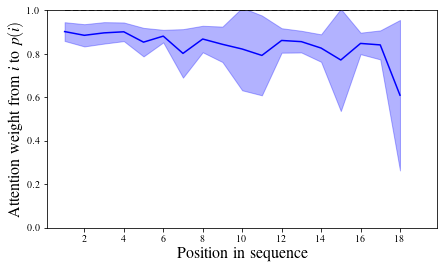

In [15]:
plt.style.use('style.mplstyle')
import matplotlib.ticker as tck

means_per_index = jnp.array([1 - jnp.mean(all_deltas[jnp.nonzero(all_deltas[:,i]), i]).item() for i in range(seq_len - 2)])
std_per_index = jnp.array([jnp.std(all_deltas[jnp.nonzero(all_deltas[:,i]), i]).item() for i in range(seq_len - 2)])
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(range(1, seq_len - 1), means_per_index, color='blue')
plt.fill_between(range(1, seq_len - 1), means_per_index - std_per_index, means_per_index + std_per_index, alpha = 0.3, color='blue')
plt.plot([1, seq_len - 1], [1., 1.], linestyle = "dashed", color = 'k')
plt.ylim(ymin = 0, ymax=1)
plt.ylabel(r"Attention weight from $i$ to $p(i)$")
plt.xlabel(r"Position in sequence")
ax.xaxis.set_major_locator(tck.MultipleLocator(2))
plt.show()
